In [373]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import pyro.distributions as dist
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of differentiable_nlp failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'TorchDistribution' is not defined
]


In [374]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


In [375]:
# Utilities
import generate_planar_scene_arrangements as psa_utils

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

. Loss:  100.009001765
. . . . tensor([[2.2624e-02, 9.8819e-01, 8.1354e-01, 4.0249e-03, 1.9529e-03, 2.6952e-01,
         1.8234e-01, 4.5458e-01, 1.2102e+00, 7.1718e-03, 5.5759e-03, 1.7465e+00,
         8.9946e-01, 9.2307e-01, 8.4081e-01, 8.9211e-03, 5.5504e-03, 3.9019e-01,
         2.5380e-01, 3.1605e-01, 1.6142e+00, 1.2884e-02, 4.1714e-03, 4.7439e+00,
         3.9908e-01, 6.1248e-01, 8.9847e-01, 2.1415e-03, 2.0995e-03, 2.7060e+00,
         4.5625e-01, 6.7595e-01, 1.7713e+00, 8.8340e-03, 9.3442e-03, 5.7294e+00,
         8.2738e-01, 7.2429e-01, 8.3171e-01, 1.0038e-02, 1.3129e-02, 3.5241e+00,
         6.6811e-01, 4.7818e-01, 9.1665e-01, 5.9429e-03, 1.2058e-02, 5.4989e+00,
         4.9029e-01, 3.3108e-02, 8.3279e-01, 9.0304e-03, 2.8152e-03, 4.9978e-01,
         4.6925e-01, 4.6655e-01, 1.3875e+00, 1.9519e-03, 7.8394e-03, 2.0007e+00]],
       dtype=torch.float64, grad_fn=<TBackward>)


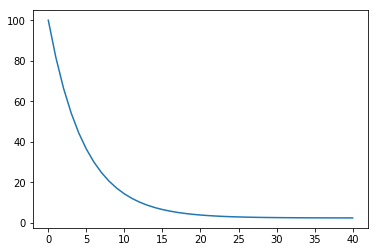

In [376]:
# Try out gradient descent through the projection operator
import differentiable_nlp as diff_nlp
from copy import deepcopy

device = torch.device('cpu')
env_i = environments[13]

rbt, qf = psa_utils.build_rbt_from_summary(env_i)
nq = rbt.get_num_positions()
#q = torch.tensor(qf.reshape(nq, 1), requires_grad=True)
np.random.seed(1)
q_start = np.random.random([nq, 1])
q = torch.tensor(q_start, requires_grad=True, dtype=torch.double)
q_target = torch.tensor(qf).view(nq, 1)

learning_rate = 0.05
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
losses = []
q_snapshots = []
q_pred_snapshots = []
for t in range(41):
    # Scheduling on the regularization in the derivative, which helps break off of
    # constraint surfaces during the first few iterations.
    q_pred = diff_nlp.projectToFeasibilityWithIKTorch.apply(q, rbt, constraints, 1/np.log(t+2))
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (q_pred - q_target).pow(2).sum()
    losses.append(loss.cpu().detach().item())
    q_snapshots.append(q.cpu().detach().numpy().copy())
    q_pred_snapshots.append(q_pred.cpu().detach().numpy().copy())
    loss.backward()
    with torch.no_grad():
        q -= learning_rate * q.grad
        # Manually zero the gradients after running the backward pass
        q.grad.zero_()
    if t % 10 == 0:
        print ".",
    if t % 100 == 0:
        print "Loss: ", loss.cpu().detach().item()

print torch.t(q)
plt.figure()
plt.plot(losses)

In [377]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_snapshots),
                              interval=2000/len(q_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [378]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_pred_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_pred_snapshots),
                              interval=2000/len(q_pred_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [383]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements WITH EXACTLY 2 OBJECTS
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml


In [482]:
# Ok, now deploy it in an inference context
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
import differentiable_nlp as diff_nlp

pyro.enable_validation(True)

class DataWrapperForObs:
    # Convenience wrapper on data:
    # If data's batch dimension is length-0,
    # we must be running the model in generative mode,
    # so any slicing returns None.
    # Otherwise, pass through slicing to the real data.
    def __init__(self, data):
        self.data = data
    def __getitem__(self, key):
        if self.data.shape[0] > 0:
            return self.data[key]
        else:
            return None

        # RBT + constraints sharable across environments
        
# Cobbling together some RBTs ahead of time for convenience
# 2-obj env
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments[0])
# 1-obj env
dummy_env = deepcopy(environments[0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
assert(two_box_rbt.get_num_positions() == 12)
assert(one_box_rbt.get_num_positions() == 6)
rbts = [one_box_rbt, two_box_rbt]

def expand_partial_pose_to_full_pose(poses):
    n_boxes = len(poses)
    full_poses = torch.zeros(poses[0].shape[0], n_boxes*6, requires_grad=poses.requires_grad, dtype=poses.dtype)
    for k in range(n_boxes):
        full_poses[:, k*6 + 0] += poses[k][:, 0]
        full_poses[:, k*6 + 1] += poses[k][:, 1]
        full_poses[:, k*6 + 2] += 0.0
        full_poses[:, k*6 + 5] = poses[k][:, 2]
    return full_poses

# Sample an exactly 2-object environment
# "data" is either None (run in generative mode),
# or is n_batches x 6 (environment pose vectors)
N_OBJECTS = 2
def model(data = torch.Tensor(0, 6), use_projection=True):
    if data.shape[1] != 6:
        raise ValueError("Expected data to have n_batches x 6 shape.")
    n = max(2, data.shape[0])
    
    data_obs = DataWrapperForObs(data)
    
    # Object placement distribution is shared across objects
    # (maybe switch this to Normal-inverse-Wishart_distribution, if supported?)
    box_mean = pyro.sample('box_mean', dist.Normal(0.5, 0.25).expand([3]).to_event(1))
    box_var = pyro.sample('box_var', dist.LogNormal(0.5, 0.25).expand([3]).to_event(1))
    box_dist = dist.MultivariateNormal(box_mean, torch.diag(box_var))
    
    generated_data = torch.zeros(n, 6)
    print "Running with n = ", n
    with pyro.plate('data', n):
        current_poses = ()
        for k in range(N_OBJECTS):
            if use_projection:
                new_pose = pyro.sample("box_%d_pre_pose" % k, box_dist)
                projection_dist = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
                    rbts[k], expand_partial_pose_to_full_pose(current_poses + (new_pose, )),
                    constraints, 0.1, 0.01)
                if k != N_OBJECTS-1:
                    projected_pose = pyro.sample("box_%d_pose" % k, projection_dist)
                else:
                    # Observe only on final generation iteration
                    # since previous projections might affect future ones
                    # (would be easier if I lock in generated object poses...)
                    projected_pose = pyro.sample("box_%d_pose" % k, obs=data_obs[:, :])
                current_poses = 
            else:
                projected_pose = pyro.sample("box_%d_pose" % k, box_dist, obs=data_obs[:, (k*3):(k*3+3)])
                current_poses = current_poses + (projected_pose,)

        for k in range(N_OBJECTS):
            generated_data[:, (k*3):(k*3+3)] = current_poses[k][:, :]

    return generated_data

print model()

Running with n =  2
constructor q0:  tensor([[-0.9454,  0.8027,  0.0000,  0.0000,  0.0000, -0.5913],
        [ 0.1373, -0.0646,  0.0000,  0.0000,  0.0000,  1.7980]])
batch shape:  torch.Size([2])
event shape:  (6,)
Expanding to  [2]
Sample shape:  torch.Size([])
Self.event_shape:  (6,)
Self.batch_shape:  torch.Size([2])
tensor([[1.3726e-01, 1.3878e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7980e+00],
        [1.3726e-01, 1.3878e-17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7980e+00]])


RuntimeError: The expanded size of the tensor (3) must match the existing size (6) at non-singleton dimension 1.  Target sizes: [2, 3].  Tensor sizes: [2, 6]

In [385]:
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y theta) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, 2*3)
    poses[:, :] = 0.
    for i, env in enumerate(envs):
        for k in range(2):
            obj = env["obj_%04d" % k]
            poses[i, (k*3):(k*3+3)] = torch.Tensor(obj["pose"])
    return poses
    
def devectorize_environments(data):
    envs = []
    for i in range(data.shape[0]):
        env = {}
        n_objects = 0
        for k in range(2):
            obj = {
                "pose": data[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": "small_box"
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = 2
        envs.append(env)
    return envs

# Make sure we can run model + condition on this dataset
model(vectorize_environments(environments))

tensor([[0.8510, 0.4892, 1.6982, 0.6158, 0.8990, 2.9663],
        [0.7750, 0.8844, 0.5871, 0.8227, 0.6387, 5.9812],
        [0.4278, 0.5484, 3.7347, 0.5774, 0.5690, 3.0618],
        ...,
        [0.4015, 0.0536, 1.6626, 0.1406, 0.2834, 4.5140],
        [0.6965, 0.2218, 5.1179, 0.9329, 0.9890, 4.9938],
        [0.4356, 0.3911, 4.6547, 0.8713, 0.9727, 4.7796]])

Selection of environments from prior / generative model


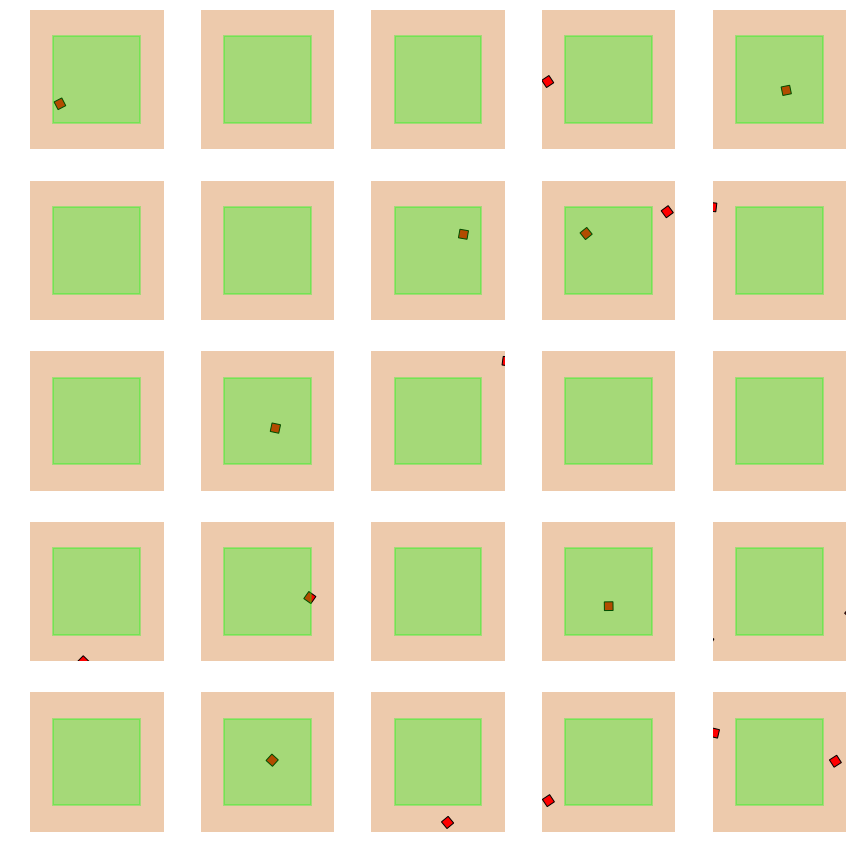

In [366]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(model())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [379]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

pyro.enable_validation(True)

global_guide = AutoMultivariateNormal(
    poutine.block(model, expose=[
        'box_mean', 'box_var']))
optim = pyro.optim.Adam({'lr': 0.05, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

losses = []
data = vectorize_environments(environments)
for i in range(401):
    loss = svi.step(data)
    losses.append(loss)
    if (i % 10 == 0):
        print ".",
    if (i % 100 == 0):
        print "\n"
        print global_guide.median()
print "Done"

[autoreload of differentiable_nlp failed: Traceback (most recent call last):
  File "/home/gizatt/miniconda3/envs/py27_pyro/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'TorchDistribution' is not defined
]


KeyError: 'obj_0001'

{'box_var': tensor([0.0838, 0.0902, 3.3613], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5088, 0.5059, 3.1297], grad_fn=<ViewBackward>)}


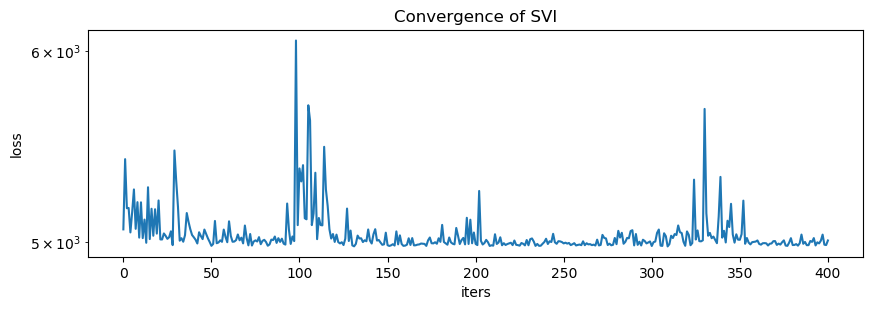

In [368]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()

Selection of environments from prior / generative model


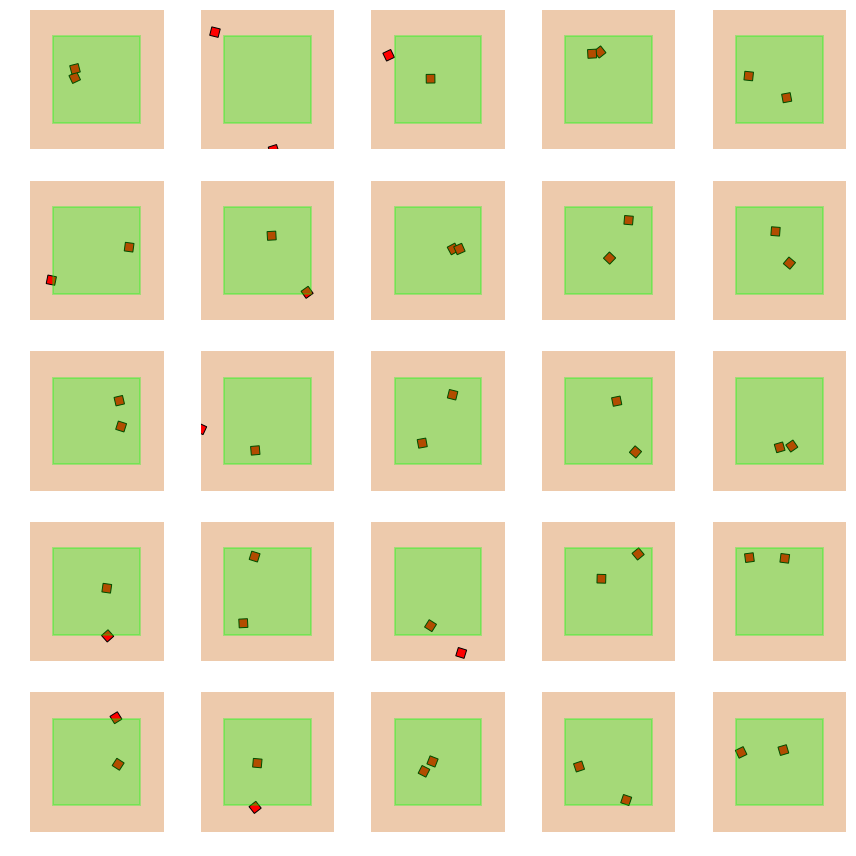

In [369]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data=global_guide.median())()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()